# Baseline performance
In this notebook, I analyze the performance for the baseline HGS-VRPTW implementation.

For each solved instance, there are three results files:
- `<inst>.txt` contains the final solution
- `<inst>.txt.PG.csv` contains the search progress for the incumbent solutions
- `<inst>.search.log` contains the entire search progress per 500 iterations

where `<inst>` denotes the instance name. Note that we skip instance `ORTEC-VRPTW-ASYM-2e2ef021-d1-n210-k17.txt` in our analysis because the instance is infeasible.

I ran the original baseline implementation for two different setups:
1. Stop after 20k no improving solutions, time limit 7200s, no restart if time limit not reached, single seed
2. Stop after 50K no improving solutions, time limit 7200s, no restart if time limit not reached, five different seeds

All experiments are run on a Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz, which is currently suggested as the CPU that will be used to evaluate our submission.

The corresponding results can be found in the folder `data/baseline/20K/` and `data/baseline/50K/<seed>/`, respectively.

In [276]:
from pathlib import Path
import os
import re

import numpy as np
import matplotlib.pyplot as plt

In [277]:
k20 = Path('../data/baseline/20K/')
k50 = Path('../data/baseline/50K/')

## Parsing functions

In [278]:
def readlines(path):
    with open(path, 'r') as fi:
        return fi.readlines()
    
def parse_solution(path):
    solution = []
    data = {}
    
    for line in readlines(path):
        if "Route" in line:
            route = [int(cust) for cust in re.match(r"Route #\d+: (.*)", line).group(1).split()]
            solution.append(route)

        else:
            key, val = line.split()
            data[key] = float(val)                

    return solution, data

    
def parse_pg(path):
    times, costs = [], []
    
    for line in readlines(path):
        inst_path, seed, cost, time = line.strip().split(';')
        times.append(float(time))
        costs.append(int(cost))
        
    return np.array(times), np.array(costs)
    
def parse_search(path):
    parse = 0
    iters, times, costs = [], [], []

    for line in readlines(path):
        if line.startswith("----- STARTING"):
            parse = 1

        elif line.startswith("----- GENETIC ALGORITHM FINISHED"):
            parse = 0

        elif parse:
            data = [section.split() for section in line.split(" | ")][:3]
            data = {section[0]: section[1:] for section in data}

            iters.append(int(data["It"][0]))
            times.append(float(data["T(s)"][0]))
            
            if "Feas" in data:
                costs.append(float(data["Feas"][1]))
            else:
                costs.append(np.nan)
    
    return {'iters': np.array(iters), 'times': np.array(times), 'costs': np.array(costs)}

In [279]:
def instances():
    """Return instance names and ignore the infeasible inst."""
    ignore = ['ORTEC-VRPTW-ASYM-2e2ef021-d1-n210-k17.txt']
    inst_dir = Path('../instances')
    return [name for name in os.listdir(inst_dir) if name not in ignore]

def inst_size(name):
    return int(name.split('-n')[1][:3])

def append(path, postfix):
    return path.with_name(f'{path.name}{postfix}')

def add(a, b):
    """Add two arrays with different sizes element-wise from left to right."""
    if len(a) < len(b):
        c = b.copy()
        c[:len(a)] += a
    else:
        c = a.copy()
        c[:len(b)] += b
    return c

In [414]:
sorted([inst_size(inst) for inst in instances()])

[200,
 200,
 200,
 201,
 201,
 203,
 203,
 204,
 204,
 205,
 205,
 206,
 208,
 210,
 211,
 212,
 212,
 212,
 213,
 214,
 214,
 214,
 214,
 215,
 215,
 217,
 219,
 220,
 220,
 220,
 220,
 222,
 224,
 225,
 225,
 225,
 225,
 226,
 226,
 227,
 230,
 230,
 231,
 234,
 234,
 235,
 236,
 236,
 237,
 237,
 237,
 237,
 238,
 238,
 239,
 239,
 240,
 241,
 246,
 247,
 247,
 248,
 249,
 250,
 252,
 252,
 252,
 253,
 254,
 254,
 254,
 254,
 255,
 257,
 258,
 259,
 261,
 262,
 262,
 262,
 263,
 263,
 265,
 265,
 266,
 267,
 268,
 268,
 268,
 270,
 270,
 273,
 273,
 274,
 275,
 277,
 277,
 283,
 284,
 285,
 285,
 286,
 287,
 288,
 288,
 288,
 290,
 290,
 291,
 292,
 293,
 296,
 296,
 296,
 296,
 299,
 299,
 299,
 299,
 300,
 301,
 302,
 302,
 302,
 304,
 305,
 307,
 308,
 309,
 309,
 309,
 310,
 310,
 311,
 313,
 313,
 313,
 316,
 317,
 318,
 318,
 319,
 320,
 320,
 321,
 322,
 323,
 324,
 325,
 325,
 326,
 326,
 327,
 327,
 328,
 328,
 328,
 329,
 329,
 329,
 329,
 329,
 330,
 331,
 332,
 332,
 335

## Average costs
We first compute the average costs over all instances for 20K and the results from 50K & all seeds.

In [288]:
costs = []

for inst in instances():
    sol, extra = parse_solution(k20 / inst)
    costs.append(extra['Cost'])

avg_20k = np.mean(costs)
print(f"Avg. cost (20K): {avg_20k:.2f}")

Avg. cost (20K): 164359.47


In [361]:
avg_all_seeds = []

for seed in range(5):
    costs = []

    for inst in instances():
        sol, data = parse_solution(k50 / str(seed) / inst)
        costs.append(data['Cost'])

    avg_cost = np.mean(costs)
    avg_all_seeds.append(avg_cost)
    print(f"Avg. cost (50K, {seed=}):    {avg_cost:.2f}")
    
avg_50k = np.mean(avg_all_seeds)
print(f"Avg. cost (50K, all seeds): {avg_50k:.2f}\n")

print(f"Improvement over 20K: {(avg_20k-avg_50k)/avg_50k * 100:.2f}%")

Avg. cost (50K, seed=0):    164274.51
Avg. cost (50K, seed=1):    164217.97
Avg. cost (50K, seed=2):    164272.29
Avg. cost (50K, seed=3):    164254.05
Avg. cost (50K, seed=4):    164280.07
Avg. cost (50K, all seeds): 164259.78

Improvement over 20K: 0.06%


Increasing the number of non-improving iterations from 20K to 50K did not help that much. FYI: In the report by Kool et al., they use 10K for non-improving iterations and reset the population until the time limit is reached. 

In the remaining part of the notebook, I'll only focus on the results from 50K.

# Best-known solutions
Although the averages do not differ per seed, we now look at the best known solutions for each instance over all seeds. We do not look at the 20K results, because I checked that they are not worse than the 50K with seed 0 results.

In [370]:
bks = []

for inst in instances():
    best_cost, best_sol = None, None
    
    for seed in range(5):
        sol, data = parse_solution(k50 / str(seed) / inst)
        cost = data['Cost']
        
        if best_cost is None or cost < best_cost:
            best_cost = cost
            best_sol = sol
    
    bks.append([inst, int(best_cost), sol])

In [371]:
avg_bks = np.mean([cost for (_, cost, _) in bks])
print(f"Avg. cost (50K, best seed):   {avg_bks:.2f}")
print(f"Improvement over average 50K: {(avg_50k-avg_bks)/avg_bks * 100:.2f}%")

Avg. cost (50K, best seed):   163961.41
Improvement over average 50K: 0.18%


There is a slight improvement if we store the best solutions for each instance over all seeds. We save these best known solutions for future comparisons:

In [372]:
with open('../data/baseline/best_known_solutions.csv', 'w') as fi:
    for (inst, cost, sol) in bks:
        fi.write(inst)
        fi.write(';')
        fi.write(str(cost))
        fi.write(';')
        fi.write(str(sol))
        fi.write('\n')

# Solution quality vs. running time
We now move on to analyze how "fast" the initial solutions converges to the best solution. We use the results from 50K and seed 0.

We normalize the initial objective to 1 and the best objective to 0. We then plot the normalized incumbent solutions against running time.

Text(0.5, 1.0, 'Convergence rate\n Baseline HGS-VRPTW\n50K non-improving iterations, seed=0')

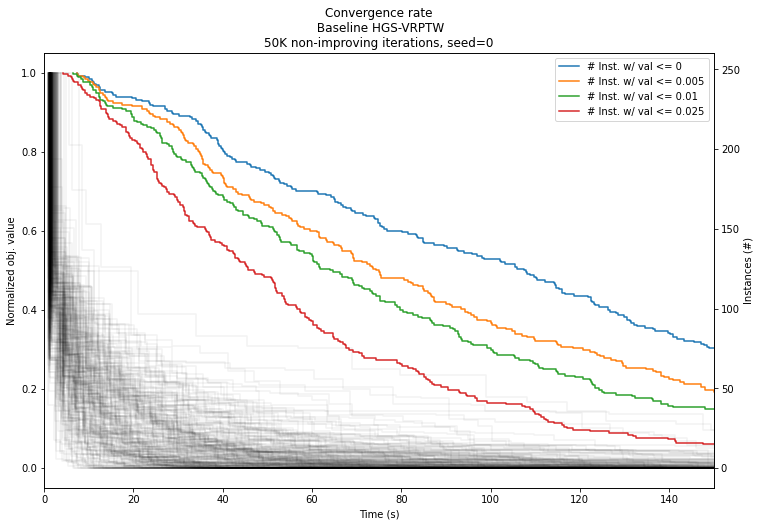

In [439]:
fig, ax1 = plt.subplots(figsize=[12, 8])
ax2 = ax1.twinx()
ax2.set_ylabel('Instances (#)')
avg_norm_costs = np.zeros(1)

gaps = [0, 0.005, 0.01, 0.025]
final = {gap: [] for gap in gaps}

for inst in instances():
    data = parse_search(append(k20 / inst, '.search.log'))

    iters, times, _costs = data['iters'], data['times'], data['costs']
    costs = np.nan_to_num(_costs, nan=np.nanmax(_costs)) # Replace infeasible with first feasible

    max_gap = costs[0] - costs[-1]
    normalized_costs = (costs - costs[-1]) / max_gap
    
    avg_norm_costs = add(avg_norm_costs, normalized_costs)
    
    for gap in gaps:
        first_hit = np.argmax(normalized_costs <= gap)
        final[gap].append(times[first_hit])

    ax1.step(times, normalized_costs, alpha=0.05, color='black')
    ax1.set_xlim(0, 150)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Normalized obj. value')

for gap in gaps:
    n_instances = np.arange(len(instances()) - 1, -1, -1)
    ax2.step(sorted(final[gap]), n_instances, label=f"# Inst. w/ val <= {gap}")


ax2.legend()
ax2.legend()
plt.title('Convergence rate\n Baseline HGS-VRPTW\n50K non-improving iterations, seed=0')

The black lines show for each solved instance the 
The colored lines show how many instances are solved within % gap w.r.t. the best solution.

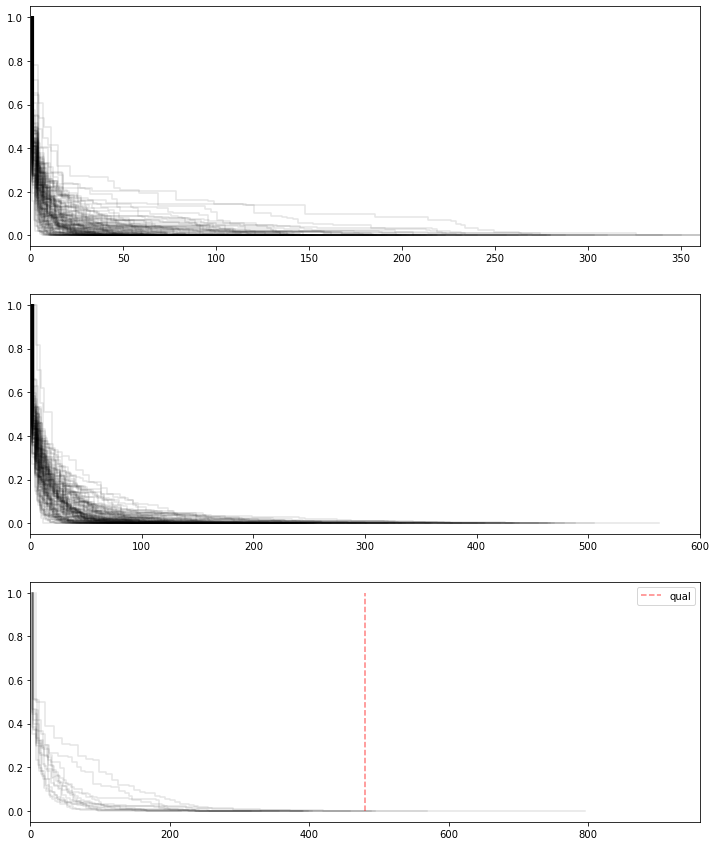

In [435]:
fig, axes = plt.subplots(3, 1, figsize=[12, 15])

def ax_num(instance_size):
    if instance_size < 300:
        return 0
    elif 300 <= instance_size <= 500:
        return 1
    elif instance_size > 500:
        return 2

for inst in instances():
    data = parse_search(append(k20 / inst, '.search.log'))

    iters, times, _costs = data['iters'], data['times'], data['costs']
    costs = np.nan_to_num(_costs, nan=np.nanmax(_costs)) # Replace infeasible with first feasible

    max_gap = costs[0] - costs[-1]
    normalized_costs = (costs - costs[-1]) / max_gap
    
    avg_norm_costs = add(avg_norm_costs, normalized_costs)
    
    for gap in gaps:
        first_hit = np.argmax(normalized_costs <= gap)
        final[gap].append(times[first_hit])

    axn = ax_num(inst_size(inst))
    axes[axn].step(times, normalized_costs, alpha=0.10, color='black')

axes[0].set_xlim(0, 180 * 2)

axes[1].set_xlim(0, 300 * 2)

axes[2].vlines(480, ymin=0, ymax=1, color='red', alpha=0.5, linestyles='dashed', label='qual')
axes[2].set_xlim(0, 480 * 2)
plt.legend()

In [ ]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=[14, 10])
ax1a = ax1.twinx()
ax1a.set_ylabel('Instances (#)')
avg_norm_costs = np.zeros(1)

gaps = [0, 0.005, 0.01, 0.025]
final = {gap: [] for gap in gaps}

for inst in instances():
    data = parse_search(append(k20 / inst, '.search.log'))

    iters, times, _costs = data['iters'], data['times'], data['costs']
    costs = np.nan_to_num(_costs, nan=np.nanmax(_costs)) # Replace infeasible with first feasible

    max_gap = costs[0] - costs[-1]
    normalized_costs = (costs - costs[-1]) / max_gap
    
    avg_norm_costs = add(avg_norm_costs, normalized_costs)
    
    for gap in gaps:
        first_hit = np.argmax(normalized_costs <= gap)
        final[gap].append(times[first_hit])

    ax1.step(times, normalized_costs, alpha=0.01, color='black')
    ax1.set_xlim(0, 150)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Gap init-best (%)')

    ax2.step(iters, normalized_costs, alpha=0.01, color='black')
    ax2.set_xlim(0, 10000)
    ax2.set_xlabel('Iterations (#)')
    ax2.set_ylabel('Gap init-best (%)')
    
for gap in gaps:
    n_instances = np.arange(len(instances()) - 1, -1, -1)
    ax1a.step(sorted(final[gap]), n_instances, label=f"# Instances with {(gap * 100)}% gap")


avg_improvement = avg_norm_costs / len(instances())
ax2.plot(np.arange(len(avg_improvement))*500, avg_improvement, color='black', label='Average improvement')

ax1a.legend()
ax2.legend()
fig.suptitle('Peformance HGS-VRPTW with 20K non-improving iterations.')